In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from venn import venn

import mpmp.config as cfg
import mpmp.utilities.tcga_utilities as tu

### Load data

Load methylation data (just 27K for now) and Illumina manifest data.

The Illumina manifest maps probes to their probe type (type I or II), their chromosome/nearest gene, their functional classification (e.g. TSS, gene body, UTR, etc), and various other information about each probe.

In [2]:
tcga_methylation_df = (
    pd.read_csv(cfg.methylation_27k_data, index_col=0, sep='\t')
      .transpose()
)

print(tcga_methylation_df.shape)
tcga_methylation_df.iloc[:5, :5]

(20040, 11975)


,TCGA-02-0001-01,TCGA-02-0003-01,TCGA-02-0006-01,TCGA-02-0007-01,TCGA-02-0009-01
cg00000292,0.8460,0.732,0.6790,0.8470,0.8550
cg00003994,0.0664,0.131,0.0897,0.0409,0.0661
cg00005847,0.3310,0.839,0.4690,0.3550,0.6050
cg00008493,0.9260,0.934,0.9250,0.9300,0.9270
cg00008713,0.0606,0.165,0.0616,0.0605,0.0614


In [3]:
if os.path.isfile(cfg.methylation_manifest):
    manifest_df = pd.read_csv(
        cfg.methylation_manifest,
        index_col=0
    )
else:
    # if manifest file hasn't already been downloaded, get it from Illumina website
    print('loading manifest from URL')
    manifest_df = pd.read_csv(
        cfg.manifest_url,
        header=7, # skip first 6 lines
        index_col=0
    )
    manifest_df.to_csv(cfg.methylation_manifest)
    
manifest_df.head()

/home/jake/anaconda3/envs/mpmp/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (2,4,11,14,15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Name,AddressA_ID,AlleleA_ProbeSeq,AddressB_ID,AlleleB_ProbeSeq,Infinium_Design_Type,Next_Base,Color_Channel,Forward_Sequence,Genome_Build,...,UCSC_RefGene_Group,UCSC_CpG_Islands_Name,Relation_to_UCSC_CpG_Island,Phantom,DMR,Enhancer,HMM_Island,Regulatory_Feature_Name,Regulatory_Feature_Group,DHS
IlmnID,,,,,,,,,,,,,,,,,,,,,
cg00035864,cg00035864,31729416,AAAACACTAACAATCTTATCCACATAAACCCTTAAATTTATCTCAA...,NaN,NaN,II,NaN,NaN,AATCCAAAGATGATGGAGGAGTGCCCGCTCATGATGTGAAGTACCT...,37.0,...,TSS1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cg00050873,cg00050873,32735311,ACAAAAAAACAACACACAACTATAATAATTTTTAAAATAAATAAAC...,3.17174e+07,ACGAAAAAACAACGCACAACTATAATAATTTTTAAAATAAATAAAC...,I,A,Red,TATCTCTGTCTGGCGAGGAGGCAACGCACAACTGTGGTGGTTTTTG...,37.0,...,Body;TSS1500,chrY:9363680-9363943,N_Shore,NaN,NaN,NaN,Y:9973136-9976273,NaN,NaN,NaN
cg00061679,cg00061679,28780415,AAAACATTAAAAAACTAATTCACTACTATTTAATTACTTTATTTTC...,NaN,NaN,II,NaN,NaN,TCAACAAATGAGAGACATTGAAGAACTAATTCACTACTATTTGGTT...,37.0,...,Body;Body;Body,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cg00063477,cg00063477,16712347,TATTCTTCCACACAAAATACTAAACRTATATTTACAAAAATACTTC...,NaN,NaN,II,NaN,NaN,CTCCTGTACTTGTTCATTAAATAATGATTCCTTGGATATACCAAGT...,37.0,...,Body,chrY:22737825-22738052,S_Shelf,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cg00121626,cg00121626,19779393,AAAACTAATAAAAATAACTTACAAACCAAATACTATACCCTACAAC...,NaN,NaN,II,NaN,NaN,AGGTGAATGAAGAGACTAATGGGAGTGGCTTGCAAGCCAGGTACTG...,37.0,...,Body,chrY:21664481-21665063,N_Shore,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Text(0.5, 1.0, 'Probe overlap between Illumina manifest and TCGA dataset')

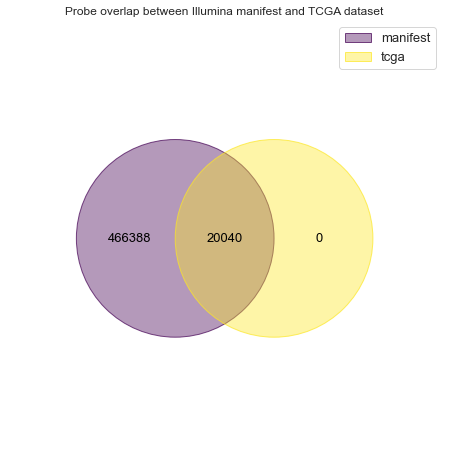

In [4]:
# look at overlap of probes in manifest and probes in TCGA dataset
# all probes in TCGA should be in manifest, but good to make sure
manifest_probes = manifest_df.index
tcga_probes = tcga_methylation_df.index

sns.set_style('white')
venn({'manifest': set(manifest_probes),
      'tcga': set(tcga_probes)})
plt.title('Probe overlap between Illumina manifest and TCGA dataset')

In [5]:
# get probe type (type I or type II) for TCGA probes from manifest
tcga_methylation_df = (tcga_methylation_df
    .merge(manifest_df[['Infinium_Design_Type', 'CHR']],
           left_index=True, right_index=True)
    .astype({'CHR': 'str'})
    .rename(columns={'Infinium_Design_Type': 'probe_type',
                     'CHR': 'chromosome'})
)
# check for NA rows, shouldn't be any
print('NA rows: {}'.format(
    tcga_methylation_df.shape[0] - tcga_methylation_df.dropna().shape[0]))
tcga_methylation_df.iloc[:5, -5:]

NA rows: 0


,TCGA-X7-A8D7-11,TCGA-YB-A89D-11,TCGA-ZU-A8S4-11,probe_type,chromosome
cg00000292,0.8800,0.6760,0.7140,II,16
cg00003994,0.0398,0.0536,0.0633,II,7
cg00005847,0.1550,0.3210,0.1530,II,2
cg00008493,0.9420,0.9300,0.9100,II,14
cg00008713,0.0612,0.0695,0.0658,II,18


### Probe filtering

We want to try removing certain classes of methylation probes:

* Probes on sex chromosomes (X or Y chromosome)
* Cross-reactive probes (these were identified in [Chen et al. 2013](https://doi.org/10.4161/epi.23470), we downloaded them using the [maxprobes R package](https://github.com/markgene/maxprobes))

Both of these probe classes could provide spurious signal for classification.

In [6]:
cross_reactive_probes = pd.read_csv(cfg.cross_reactive_probe_list, 
                                    header=None,
                                    index_col=0,
                                    squeeze=True)
cross_reactive_probes.head()

""
0
cg00001510
cg00003969
cg00004121
cg00004192
cg00004209


Text(0.5, 1.0, 'Probe overlap between cross-reactive probe list and TCGA dataset')

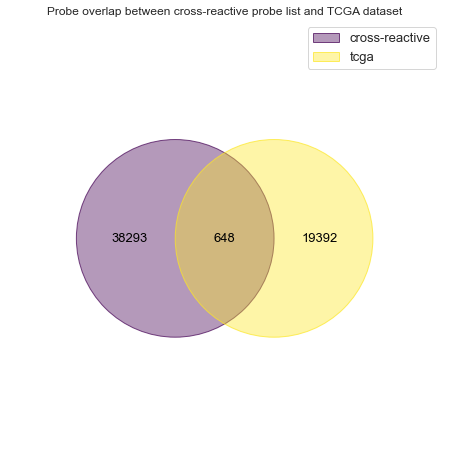

In [7]:
# look at overlap of cross-reactive probes and probes in TCGA dataset
sns.set_style('white')
venn({'cross-reactive': set(cross_reactive_probes.index),
      'tcga': set(tcga_probes)})
plt.title('Probe overlap between cross-reactive probe list and TCGA dataset')

In [8]:
print(tcga_methylation_df.shape)
tcga_methylation_df = (
    tcga_methylation_df[(~tcga_methylation_df.chromosome.isin(['X', 'Y'])) &
                        (~tcga_methylation_df.index.isin(cross_reactive_probes.index))]
)
print(tcga_methylation_df.shape)

(20040, 11977)
(18698, 11977)


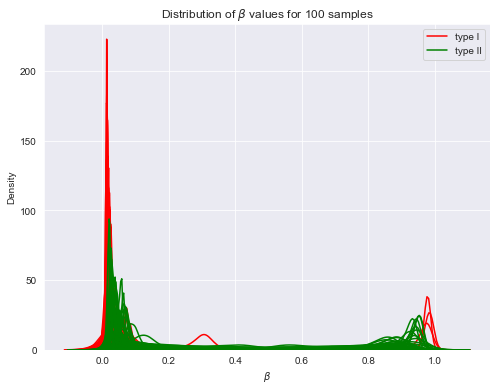

In [9]:
# sample n_samples probes of each type
# using all the samples takes forever to run and produces a plot that's hard to read
n_samples = 100
tI_probes = (
    tcga_methylation_df[tcga_methylation_df.probe_type == 'I']
      .sample(n=n_samples, random_state=cfg.default_seed)
)
tII_probes = (
    tcga_methylation_df[tcga_methylation_df.probe_type == 'II']
      .sample(n=n_samples, random_state=cfg.default_seed)
)

sns.set_style('whitegrid')
sns.set({'figure.figsize': (8, 6)})
 
for ix, (probe, row) in enumerate(tI_probes.iterrows()):
    betas = row.values[:-2].astype('float')
    if ix == 0:
        sns.kdeplot(x=betas, color='red', label='type I')
    else:
        sns.kdeplot(x=betas, color='red')
    
for ix, (probe, row) in enumerate(tII_probes.iterrows()):
    betas = row.values[:-2].astype('float')
    if ix == 0:
        sns.kdeplot(x=betas, color='green', label='type II')
    else:
        sns.kdeplot(x=betas, color='green')
    
plt.title(r'Distribution of $\beta$ values for {} samples'.format(n_samples))
plt.xlabel(r'$\beta$')
plt.legend()

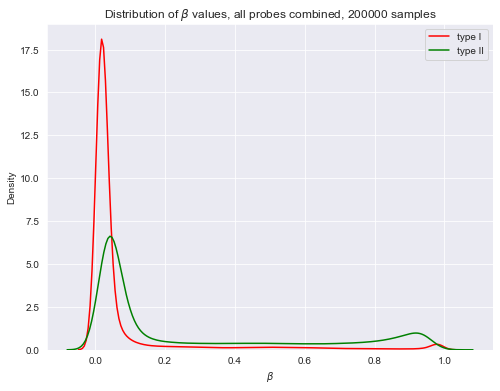

In [10]:
# single distribution from all probes of each type
# this takes a while
n_samples = 200000
all_tI_probes = np.random.choice(
    tcga_methylation_df[tcga_methylation_df.probe_type == 'I']
      .drop(columns=['probe_type', 'chromosome'])
      .values.astype('float').flatten()
, size=n_samples)
all_tII_probes = np.random.choice(
    tcga_methylation_df[tcga_methylation_df.probe_type == 'II']
      .drop(columns=['probe_type', 'chromosome'])
      .values.astype('float').flatten()
, size=n_samples)

sns.set_style('whitegrid')
sns.set({'figure.figsize': (8, 6)})
 
sns.kdeplot(x=all_tI_probes, color='red', label='type I')
sns.kdeplot(x=all_tII_probes, color='green', label='type II')
    
plt.title(r'Distribution of $\beta$ values, all probes combined, {} samples'.format(n_samples))
plt.xlabel(r'$\beta$')
plt.legend()